# AlexNet

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision.models as models
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

In [2]:
LABELS_CSV_PATH = '/kaggle/input/ffpp-fix/labels.csv'
NEW_BASE_PATH = "/kaggle/input/ffpp-fix/frames_cropped_new/"
IMG_SIZE = 224 
BATCH_SIZE = 32 
LEARNING_RATE = 1e-4 
EPOCHS = 50
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
try:
    labels_df = pd.read_csv(LABELS_CSV_PATH)
    labels_df['filepath'] = labels_df['filepath'].apply(lambda x: os.path.join(NEW_BASE_PATH, os.path.basename(x)))
    print(f"Successfully loaded labels.csv. Number of entries: {len(labels_df)}")
except FileNotFoundError:
    print(f"Error: {LABELS_CSV_PATH} not found. Please check the path.")
    exit()
except Exception as e:
    print(f"Error loading or processing labels_df: {e}")
    exit()

try:
    if labels_df['label'].dtype != 'int':
        labels_df['label'] = labels_df['label'].astype(int)
    NUM_CLASSES = labels_df['label'].nunique()
    if NUM_CLASSES == 0:
        raise ValueError("No unique classes found in 'label' column.")
    print(f"Number of unique classes: {NUM_CLASSES}")
except Exception as e:
    print(f"Error determining number of classes or processing 'label' column: {e}")
    print("Please ensure your 'label' column in labels.csv contains integer class indices (e.g., 0, 1, 2...).")
    exit()

Successfully loaded labels.csv. Number of entries: 6974
Number of unique classes: 2


In [4]:
class CustomImageDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['filepath']
        label = int(self.dataframe.iloc[idx]['label'])

        if not os.path.exists(img_path):
            print(f"Warning: File not found (idx {idx}): {img_path}. Returning None.")
            return None, None

        try:
            image = cv2.imread(img_path)
            if image is None:
                print(f"Warning: Could not read image (idx {idx}) {img_path} (cv2.imread failed). Skipping.")
                return None, None
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        except Exception as e:
            print(f"Error loading image (idx {idx}) {img_path} with cv2: {e}")
            return None, None

        if self.transform:
            try:
                image = self.transform(image) 
            except Exception as e:
                print(f"Error applying transform to image (idx {idx}) {img_path}: {e}")
                return None, None
        
        if image is None: 
             print(f"Warning: Image became None unexpectedly before tensor conversion (idx {idx}) {img_path}. Skipping.")
             return None, None

        return image, torch.tensor(label, dtype=torch.long)

In [5]:

train_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(256),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomAffine(
        degrees=10,
        translate=(0.1, 0.1),
        scale=(0.9, 1.1),
        shear=0.1,
        fill=0
    ),
    transforms.ToTensor(),
])

test_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [6]:
valid_indices = [i for i, row in labels_df.iterrows() if os.path.exists(row['filepath'])]
if len(valid_indices) < len(labels_df):
    print(f"Warning: {len(labels_df) - len(valid_indices)} image paths were invalid and removed.")
    labels_df_filtered = labels_df.iloc[valid_indices].reset_index(drop=True)
else:
    labels_df_filtered = labels_df

if len(labels_df_filtered) == 0:
    print("No valid image paths found after filtering. Exiting.")
    exit()

stratify_column = labels_df_filtered['label']

if NUM_CLASSES <= 1: # Stratification requires at least 2 classes
    train_df, test_df = train_test_split(labels_df_filtered, test_size=0.2, random_state=42)
    print("Warning: Number of classes is 1 or less, stratification is disabled.")
else:
    try:
        train_df, test_df = train_test_split(labels_df_filtered, test_size=0.2, random_state=42, stratify=stratify_column)
    except ValueError as e:
        print(f"Error during train_test_split stratification: {e}")
        print("This can happen if a class has too few samples. Falling back to non-stratified split.")
        train_df, test_df = train_test_split(labels_df_filtered, test_size=0.2, random_state=42)


print(f"Training samples: {len(train_df)}, Test samples: {len(test_df)}")

Training samples: 5579, Test samples: 1395


In [7]:
def collate_fn_skip_none(batch):
    batch = list(filter(lambda x: x[0] is not None, batch))
    if not batch: 
        return torch.Tensor(), torch.Tensor() 
    return torch.utils.data.dataloader.default_collate(batch)

train_dataset = CustomImageDataset(train_df, transform=train_transforms)
test_dataset = CustomImageDataset(test_df, transform=test_transforms)

def collate_fn_skip_none(batch):
    batch = list(filter(lambda x: x[0] is not None and x[1] is not None, batch))
    if not batch:
        return torch.Tensor(), torch.Tensor()
    return torch.utils.data.dataloader.default_collate(batch)

train_dataset = CustomImageDataset(train_df, transform=train_transforms)
test_dataset = CustomImageDataset(test_df, transform=test_transforms)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True, collate_fn=collate_fn_skip_none)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True, collate_fn=collate_fn_skip_none)

In [8]:
# Inisialisasi model custom CNN
model = models.resnet18(weights=None, num_classes=NUM_CLASSES).to(DEVICE)

# Setup loss dan optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)


In [9]:
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    progress_bar_train = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Train]", unit="batch")
    for inputs, labels in progress_bar_train:
        if inputs.nelement() == 0:
            continue
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        labels = labels.long()  # penting untuk CrossEntropyLoss

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
        progress_bar_train.set_postfix(loss=loss.item())

    epoch_loss = running_loss / total_train if total_train > 0 else 0
    epoch_acc = (correct_train / total_train) * 100 if total_train > 0 else 0
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    # ----- Validation -----
    model.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0
    all_preds = []
    all_labels = []

    progress_bar_val = tqdm(test_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Val]", unit="batch")
    with torch.no_grad():
        for inputs, labels in progress_bar_val:
            if inputs.nelement() == 0:
                continue
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            labels = labels.long()

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            progress_bar_val.set_postfix(loss=loss.item())

    val_loss = running_val_loss / total_val if total_val > 0 else 0
    val_acc = (correct_val / total_val) * 100 if total_val > 0 else 0
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{EPOCHS} - Train Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.2f}% | Val Loss: {val_loss:.4f}, Acc: {val_acc:.2f}%")


Epoch 1/50 [Train]:   0%|          | 0/175 [00:00<?, ?batch/s]

Epoch 1/50 [Val]:   0%|          | 0/44 [00:00<?, ?batch/s]

Epoch 1/50 - Train Loss: 0.4253, Acc: 85.02% | Val Loss: 0.4026, Acc: 85.66%


Epoch 2/50 [Train]:   0%|          | 0/175 [00:00<?, ?batch/s]

Epoch 2/50 [Val]:   0%|          | 0/44 [00:00<?, ?batch/s]

Epoch 2/50 - Train Loss: 0.4054, Acc: 85.50% | Val Loss: 0.4461, Acc: 83.44%


Epoch 3/50 [Train]:   0%|          | 0/175 [00:00<?, ?batch/s]

Epoch 3/50 [Val]:   0%|          | 0/44 [00:00<?, ?batch/s]

Epoch 3/50 - Train Loss: 0.4004, Acc: 85.45% | Val Loss: 0.3942, Acc: 85.66%


Epoch 4/50 [Train]:   0%|          | 0/175 [00:00<?, ?batch/s]

Epoch 4/50 [Val]:   0%|          | 0/44 [00:00<?, ?batch/s]

Epoch 4/50 - Train Loss: 0.3964, Acc: 85.64% | Val Loss: 0.4021, Acc: 86.02%


Epoch 5/50 [Train]:   0%|          | 0/175 [00:00<?, ?batch/s]

Epoch 5/50 [Val]:   0%|          | 0/44 [00:00<?, ?batch/s]

Epoch 5/50 - Train Loss: 0.3898, Acc: 85.68% | Val Loss: 0.4666, Acc: 79.43%


Epoch 6/50 [Train]:   0%|          | 0/175 [00:00<?, ?batch/s]

Epoch 6/50 [Val]:   0%|          | 0/44 [00:00<?, ?batch/s]

Epoch 6/50 - Train Loss: 0.3918, Acc: 85.68% | Val Loss: 0.3827, Acc: 85.73%


Epoch 7/50 [Train]:   0%|          | 0/175 [00:00<?, ?batch/s]

Epoch 7/50 [Val]:   0%|          | 0/44 [00:00<?, ?batch/s]

Epoch 7/50 - Train Loss: 0.3868, Acc: 85.82% | Val Loss: 0.4262, Acc: 84.44%


Epoch 8/50 [Train]:   0%|          | 0/175 [00:00<?, ?batch/s]

Epoch 8/50 [Val]:   0%|          | 0/44 [00:00<?, ?batch/s]

Epoch 8/50 - Train Loss: 0.3893, Acc: 85.75% | Val Loss: 0.3905, Acc: 85.66%


Epoch 9/50 [Train]:   0%|          | 0/175 [00:00<?, ?batch/s]

Epoch 9/50 [Val]:   0%|          | 0/44 [00:00<?, ?batch/s]

Epoch 9/50 - Train Loss: 0.3859, Acc: 85.68% | Val Loss: 0.4111, Acc: 83.73%


Epoch 10/50 [Train]:   0%|          | 0/175 [00:00<?, ?batch/s]

Epoch 10/50 [Val]:   0%|          | 0/44 [00:00<?, ?batch/s]

Epoch 10/50 - Train Loss: 0.3816, Acc: 85.82% | Val Loss: 0.3900, Acc: 85.59%


Epoch 11/50 [Train]:   0%|          | 0/175 [00:00<?, ?batch/s]

Epoch 11/50 [Val]:   0%|          | 0/44 [00:00<?, ?batch/s]

Epoch 11/50 - Train Loss: 0.3779, Acc: 85.73% | Val Loss: 0.3991, Acc: 85.66%


Epoch 12/50 [Train]:   0%|          | 0/175 [00:00<?, ?batch/s]

Epoch 12/50 [Val]:   0%|          | 0/44 [00:00<?, ?batch/s]

Epoch 12/50 - Train Loss: 0.3796, Acc: 85.82% | Val Loss: 0.3887, Acc: 85.66%


Epoch 13/50 [Train]:   0%|          | 0/175 [00:00<?, ?batch/s]

Epoch 13/50 [Val]:   0%|          | 0/44 [00:00<?, ?batch/s]

Epoch 13/50 - Train Loss: 0.3770, Acc: 85.82% | Val Loss: 0.3906, Acc: 85.88%


Epoch 14/50 [Train]:   0%|          | 0/175 [00:00<?, ?batch/s]

Epoch 14/50 [Val]:   0%|          | 0/44 [00:00<?, ?batch/s]

Epoch 14/50 - Train Loss: 0.3776, Acc: 85.86% | Val Loss: 0.3818, Acc: 86.09%


Epoch 15/50 [Train]:   0%|          | 0/175 [00:00<?, ?batch/s]

Epoch 15/50 [Val]:   0%|          | 0/44 [00:00<?, ?batch/s]

Epoch 15/50 - Train Loss: 0.3761, Acc: 85.57% | Val Loss: 0.3876, Acc: 85.88%


Epoch 16/50 [Train]:   0%|          | 0/175 [00:00<?, ?batch/s]

Epoch 16/50 [Val]:   0%|          | 0/44 [00:00<?, ?batch/s]

Epoch 16/50 - Train Loss: 0.3719, Acc: 85.88% | Val Loss: 0.3970, Acc: 85.81%


Epoch 17/50 [Train]:   0%|          | 0/175 [00:00<?, ?batch/s]

Epoch 17/50 [Val]:   0%|          | 0/44 [00:00<?, ?batch/s]

Epoch 17/50 - Train Loss: 0.3718, Acc: 85.80% | Val Loss: 0.3948, Acc: 85.52%


Epoch 18/50 [Train]:   0%|          | 0/175 [00:00<?, ?batch/s]

Epoch 18/50 [Val]:   0%|          | 0/44 [00:00<?, ?batch/s]

Epoch 18/50 - Train Loss: 0.3707, Acc: 85.82% | Val Loss: 0.3931, Acc: 85.66%


Epoch 19/50 [Train]:   0%|          | 0/175 [00:00<?, ?batch/s]

Epoch 19/50 [Val]:   0%|          | 0/44 [00:00<?, ?batch/s]

Epoch 19/50 - Train Loss: 0.3668, Acc: 85.73% | Val Loss: 0.4046, Acc: 83.87%


Epoch 20/50 [Train]:   0%|          | 0/175 [00:00<?, ?batch/s]

Epoch 20/50 [Val]:   0%|          | 0/44 [00:00<?, ?batch/s]

Epoch 20/50 - Train Loss: 0.3664, Acc: 85.79% | Val Loss: 0.3872, Acc: 85.52%


Epoch 21/50 [Train]:   0%|          | 0/175 [00:00<?, ?batch/s]

Epoch 21/50 [Val]:   0%|          | 0/44 [00:00<?, ?batch/s]

Epoch 21/50 - Train Loss: 0.3680, Acc: 85.89% | Val Loss: 0.4186, Acc: 84.16%


Epoch 22/50 [Train]:   0%|          | 0/175 [00:00<?, ?batch/s]

Epoch 22/50 [Val]:   0%|          | 0/44 [00:00<?, ?batch/s]

Epoch 22/50 - Train Loss: 0.3636, Acc: 85.73% | Val Loss: 0.4163, Acc: 83.08%


Epoch 23/50 [Train]:   0%|          | 0/175 [00:00<?, ?batch/s]

Epoch 23/50 [Val]:   0%|          | 0/44 [00:00<?, ?batch/s]

Epoch 23/50 - Train Loss: 0.3633, Acc: 85.64% | Val Loss: 0.3933, Acc: 85.45%


Epoch 24/50 [Train]:   0%|          | 0/175 [00:00<?, ?batch/s]

Epoch 24/50 [Val]:   0%|          | 0/44 [00:00<?, ?batch/s]

Epoch 24/50 - Train Loss: 0.3617, Acc: 85.95% | Val Loss: 0.4342, Acc: 83.23%


Epoch 25/50 [Train]:   0%|          | 0/175 [00:00<?, ?batch/s]

Epoch 25/50 [Val]:   0%|          | 0/44 [00:00<?, ?batch/s]

Epoch 25/50 - Train Loss: 0.3599, Acc: 85.89% | Val Loss: 0.3870, Acc: 85.81%


Epoch 26/50 [Train]:   0%|          | 0/175 [00:00<?, ?batch/s]

Epoch 26/50 [Val]:   0%|          | 0/44 [00:00<?, ?batch/s]

Epoch 26/50 - Train Loss: 0.3526, Acc: 85.84% | Val Loss: 0.3834, Acc: 85.95%


Epoch 27/50 [Train]:   0%|          | 0/175 [00:00<?, ?batch/s]

Epoch 27/50 [Val]:   0%|          | 0/44 [00:00<?, ?batch/s]

Epoch 27/50 - Train Loss: 0.3525, Acc: 86.20% | Val Loss: 0.4007, Acc: 85.23%


Epoch 28/50 [Train]:   0%|          | 0/175 [00:00<?, ?batch/s]

Epoch 28/50 [Val]:   0%|          | 0/44 [00:00<?, ?batch/s]

Epoch 28/50 - Train Loss: 0.3520, Acc: 85.75% | Val Loss: 0.4046, Acc: 84.16%


Epoch 29/50 [Train]:   0%|          | 0/175 [00:00<?, ?batch/s]

Epoch 29/50 [Val]:   0%|          | 0/44 [00:00<?, ?batch/s]

Epoch 29/50 - Train Loss: 0.3476, Acc: 86.20% | Val Loss: 0.3821, Acc: 86.09%


Epoch 30/50 [Train]:   0%|          | 0/175 [00:00<?, ?batch/s]

Epoch 30/50 [Val]:   0%|          | 0/44 [00:00<?, ?batch/s]

Epoch 30/50 - Train Loss: 0.3472, Acc: 86.40% | Val Loss: 0.3967, Acc: 86.09%


Epoch 31/50 [Train]:   0%|          | 0/175 [00:00<?, ?batch/s]

Epoch 31/50 [Val]:   0%|          | 0/44 [00:00<?, ?batch/s]

Epoch 31/50 - Train Loss: 0.3453, Acc: 86.11% | Val Loss: 0.4148, Acc: 83.80%


Epoch 32/50 [Train]:   0%|          | 0/175 [00:00<?, ?batch/s]

Epoch 32/50 [Val]:   0%|          | 0/44 [00:00<?, ?batch/s]

Epoch 32/50 - Train Loss: 0.3483, Acc: 86.14% | Val Loss: 0.3927, Acc: 85.81%


Epoch 33/50 [Train]:   0%|          | 0/175 [00:00<?, ?batch/s]

Epoch 33/50 [Val]:   0%|          | 0/44 [00:00<?, ?batch/s]

Epoch 33/50 - Train Loss: 0.3401, Acc: 86.14% | Val Loss: 0.4132, Acc: 85.38%


Epoch 34/50 [Train]:   0%|          | 0/175 [00:00<?, ?batch/s]

Epoch 34/50 [Val]:   0%|          | 0/44 [00:00<?, ?batch/s]

Epoch 34/50 - Train Loss: 0.3396, Acc: 86.32% | Val Loss: 0.4033, Acc: 85.59%


Epoch 35/50 [Train]:   0%|          | 0/175 [00:00<?, ?batch/s]

Epoch 35/50 [Val]:   0%|          | 0/44 [00:00<?, ?batch/s]

Epoch 35/50 - Train Loss: 0.3436, Acc: 86.00% | Val Loss: 0.4113, Acc: 84.73%


Epoch 36/50 [Train]:   0%|          | 0/175 [00:00<?, ?batch/s]

Epoch 36/50 [Val]:   0%|          | 0/44 [00:00<?, ?batch/s]

Epoch 36/50 - Train Loss: 0.3301, Acc: 86.72% | Val Loss: 0.4212, Acc: 83.15%


Epoch 37/50 [Train]:   0%|          | 0/175 [00:00<?, ?batch/s]

Epoch 37/50 [Val]:   0%|          | 0/44 [00:00<?, ?batch/s]

Epoch 37/50 - Train Loss: 0.3293, Acc: 86.32% | Val Loss: 0.4458, Acc: 82.15%


Epoch 38/50 [Train]:   0%|          | 0/175 [00:00<?, ?batch/s]

Epoch 38/50 [Val]:   0%|          | 0/44 [00:00<?, ?batch/s]

Epoch 38/50 - Train Loss: 0.3270, Acc: 86.20% | Val Loss: 0.4502, Acc: 85.88%


Epoch 39/50 [Train]:   0%|          | 0/175 [00:00<?, ?batch/s]

Epoch 39/50 [Val]:   0%|          | 0/44 [00:00<?, ?batch/s]

Epoch 39/50 - Train Loss: 0.3300, Acc: 86.68% | Val Loss: 0.4161, Acc: 84.37%


Epoch 40/50 [Train]:   0%|          | 0/175 [00:00<?, ?batch/s]

Epoch 40/50 [Val]:   0%|          | 0/44 [00:00<?, ?batch/s]

Epoch 40/50 - Train Loss: 0.3195, Acc: 86.59% | Val Loss: 0.4469, Acc: 83.87%


Epoch 41/50 [Train]:   0%|          | 0/175 [00:00<?, ?batch/s]

Epoch 41/50 [Val]:   0%|          | 0/44 [00:00<?, ?batch/s]

Epoch 41/50 - Train Loss: 0.3187, Acc: 86.63% | Val Loss: 0.4562, Acc: 83.01%


Epoch 42/50 [Train]:   0%|          | 0/175 [00:00<?, ?batch/s]

Epoch 42/50 [Val]:   0%|          | 0/44 [00:00<?, ?batch/s]

Epoch 42/50 - Train Loss: 0.3222, Acc: 86.95% | Val Loss: 0.4165, Acc: 85.73%


Epoch 43/50 [Train]:   0%|          | 0/175 [00:00<?, ?batch/s]

Epoch 43/50 [Val]:   0%|          | 0/44 [00:00<?, ?batch/s]

Epoch 43/50 - Train Loss: 0.3165, Acc: 86.63% | Val Loss: 0.4703, Acc: 78.78%


Epoch 44/50 [Train]:   0%|          | 0/175 [00:00<?, ?batch/s]

Epoch 44/50 [Val]:   0%|          | 0/44 [00:00<?, ?batch/s]

Epoch 44/50 - Train Loss: 0.3087, Acc: 87.42% | Val Loss: 0.4409, Acc: 82.94%


Epoch 45/50 [Train]:   0%|          | 0/175 [00:00<?, ?batch/s]

Epoch 45/50 [Val]:   0%|          | 0/44 [00:00<?, ?batch/s]

Epoch 45/50 - Train Loss: 0.3165, Acc: 86.43% | Val Loss: 0.4671, Acc: 80.29%


Epoch 46/50 [Train]:   0%|          | 0/175 [00:00<?, ?batch/s]

Epoch 46/50 [Val]:   0%|          | 0/44 [00:00<?, ?batch/s]

Epoch 46/50 - Train Loss: 0.3052, Acc: 87.09% | Val Loss: 0.4695, Acc: 80.36%


Epoch 47/50 [Train]:   0%|          | 0/175 [00:00<?, ?batch/s]

Epoch 47/50 [Val]:   0%|          | 0/44 [00:00<?, ?batch/s]

Epoch 47/50 - Train Loss: 0.3083, Acc: 87.18% | Val Loss: 0.5183, Acc: 76.77%


Epoch 48/50 [Train]:   0%|          | 0/175 [00:00<?, ?batch/s]

Epoch 48/50 [Val]:   0%|          | 0/44 [00:00<?, ?batch/s]

Epoch 48/50 - Train Loss: 0.3002, Acc: 87.15% | Val Loss: 0.4912, Acc: 78.92%


Epoch 49/50 [Train]:   0%|          | 0/175 [00:00<?, ?batch/s]

Epoch 49/50 [Val]:   0%|          | 0/44 [00:00<?, ?batch/s]

Epoch 49/50 - Train Loss: 0.3022, Acc: 87.22% | Val Loss: 0.4502, Acc: 83.66%


Epoch 50/50 [Train]:   0%|          | 0/175 [00:00<?, ?batch/s]

Epoch 50/50 [Val]:   0%|          | 0/44 [00:00<?, ?batch/s]

Epoch 50/50 - Train Loss: 0.3018, Acc: 86.70% | Val Loss: 0.4318, Acc: 83.80%



Starting Final Testing Phase...


Final Testing:   0%|          | 0/44 [00:00<?, ?batch/s]

Final Test Loss: 0.4318
Final Test Accuracy: 83.80%

Generating Confusion Matrix from Final Test Results...


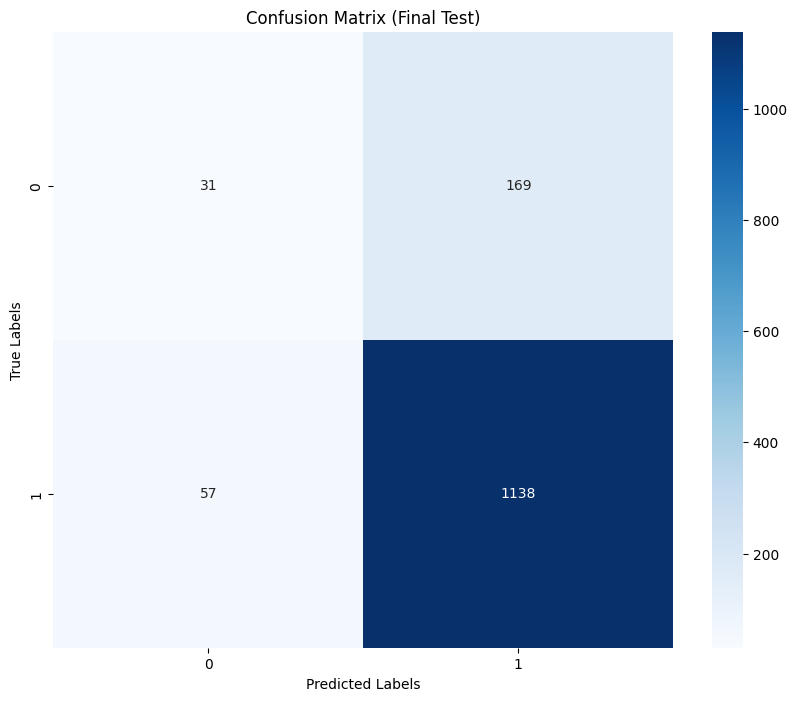

Model saved to alexnet_pytorch.pth


In [10]:
print("\nStarting Final Testing Phase...")
model.eval()  

final_test_loss = 0.0
final_correct_test = 0
final_total_test = 0
final_all_preds = []
final_all_labels = []

with torch.no_grad(): 
    for inputs, labels in tqdm(test_loader, desc="Final Testing", unit="batch"): 
        if inputs.nelement() == 0: 
            continue
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        
        outputs = model(inputs)
        loss = criterion(outputs, labels) 

        final_test_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        final_total_test += labels.size(0)
        final_correct_test += (predicted == labels).sum().item()

        final_all_preds.extend(predicted.cpu().numpy())
        final_all_labels.extend(labels.cpu().numpy())

if final_total_test > 0:
    avg_final_test_loss = final_test_loss / final_total_test
    final_test_accuracy = (final_correct_test / final_total_test) * 100
    print(f"Final Test Loss: {avg_final_test_loss:.4f}")
    print(f"Final Test Accuracy: {final_test_accuracy:.2f}%")
else:
    print("No data was processed in the test loader during final testing.")

if final_total_test > 0:
    print("\nGenerating Confusion Matrix from Final Test Results...")
    cm = confusion_matrix(final_all_labels, final_all_preds) 
    plt.figure(figsize=(10, 8))
    class_names = [str(i) for i in range(NUM_CLASSES)] 
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix (Final Test)')
    plt.show()
else:
    print("No data was processed in the test loader, cannot generate confusion matrix.")

torch.save(model.state_dict(), 'alexnet_pytorch.pth')
print("Model saved to alexnet_pytorch.pth")

In [11]:
from IPython.display import FileLink

display(FileLink('alexnet_pytorch.pth'))

/kaggle/working/alexnet_pytorch.pth